In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
from tensorflow import keras
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import glob
import scipy.io as sio
import seaborn as sns
import tqdm
from IPython.display import clear_output

In [3]:
def shapeNposition_w(mod, see=True, plot=False):
  weights=mod.get_weights()
  print('Number of layers: ', np.shape(weights))
  cont=1
  cont_l=[]
  sh=[]
  ker=[]
  shp_0=(0,0,0,0)
  positions=[]

  for n,i in enumerate(weights):
    if  len(np.shape(i))==4:
      shp_1=np.shape(i)
      if see:    
        if shp_1[2]!=shp_0[3]:
          print('Position:', n, '\tlayer No.:', cont, '\t', np.shape(i), '*')
        else:
          print('Position:', n, '\tlayer No.:', cont, '\t', np.shape(i))
      positions=np.append(positions,n)
      cont_l=np.append(cont_l,cont)
      ker=np.append(ker,np.shape(i)[-1])
      sh=np.append(sh,str(np.shape(i)[:2]))

      shp_0=shp_1
      cont=cont+1

  if plot:
    sns.set_theme(style="darkgrid")
    plt.figure(figsize=(20,7))
    plt.bar(cont_l, ker)
    plt.xlabel('Convolutional layers')
    plt.ylabel('Number of filters (kernels)')
    plt.title('ResNet50v2')
    for i in range(np.shape(ker)[0]):
      plt.text(cont_l[i],ker[i], sh[i], horizontalalignment='center', verticalalignment='bottom', rotation='vertical')

  positions=positions.astype('int')
  return positions

In [4]:
def positionNnameLayers(mod, see=True, layer='conv'):
  layer_f={'conv':'.convolutional.Conv2D', 'block': '.merge.Add', 'all':'layers'}
  position=[]
  names=[]
  cont=0
  for n, i in enumerate(mod.layers):
    if str(i).find(layer_f[layer])!=-1:
      cont=cont+1
      name_conv=i.name
      names=np.append(names,name_conv)
      if see:
        print(n, cont, name_conv)
      position=np.append(position,n)
  return names

### Datasets

In [5]:
path="/content/drive/MyDrive/INDIGO_MLR/TumoresCerebrales/"
mats=glob.glob(path+'imag*.mat')
print(np.shape(mats))

(7,)


In [6]:
def download_mri():
  images=[]
  labels=[]

  for n, i in enumerate(mats):
    data=sio.loadmat(i)
    n_sub,rows,cols=np.shape(data['images'])
    labels=np.append(labels,data['labels'][0])
    ima=np.array(data['images'], np.dtype('float32')).reshape((n_sub,rows,cols,1))
    if n==0:   
      images=ima
    else:
      images=np.concatenate((images,ima))

  images=tf.image.resize(images, [256,256], method='nearest')
  images=tf.image.grayscale_to_rgb(images)
  return images

In [7]:
def get_images_mr(batch=20):
  images=download_mri()
  sz=np.shape(images)[0]
  idx=np.random.choice(sz-batch-1)
  return images[idx:idx+batch]

In [8]:
def get_images_cifar(batch=256):
  cifar10 = tf.keras.datasets.cifar10
  (x_train, y_train), (x_test, y_test) = cifar10.load_data()
  x_train, x_test = x_train / 255.0, x_test / 255.0 #rescale the data
  return x_train[:batch]

In [9]:
def get_images(dataset='cifar'):
  if dataset=='cifar':
    return get_images_cifar()
  if dataset=='MRI':
    return get_images_mr()

### Activation layers

In [10]:
def activation_layers(mod, layer_n, img_t, pos=0, see=False):
  layer = mod.get_layer(name=layer_n[pos])
  activation_model=keras.Model(inputs=mod.inputs, outputs=layer.output)
  activations = activation_model.predict(img_t)

  if see:
    siz=np.shape(activations)
    num_k=siz[-1]
    col=int(np.sqrt(num_k))
    row=(num_k//col)+int((num_k%col)!=0)
    plt.figure(figsize=(20,20))
    for i in range(num_k):
      plt.subplot(row,col,i+1)
      plt.imshow(activations[0,:,:,i])
      plt.axis('off')
  return activations

### Similitud entre mapas de activación generados por cada capa

In [11]:
def unbiased_HSIC(K, L):
  '''Computes an unbiased estimator of HISC. This is equation (2) from the paper'''

  #create the unit **vector** filled with ones
  n = K.shape[0]
  ones = np.ones(shape=(n))

  #fill the diagonal entries with zeros 
  np.fill_diagonal(K, val=0) #this is now K_tilde 
  np.fill_diagonal(L, val=0) #this is now L_tilde

  #first part in the square brackets
  trace = np.trace(np.dot(K, L))

  #middle part in the square brackets
  nominator1 = np.dot(np.dot(ones.T, K), ones)
  nominator2 = np.dot(np.dot(ones.T, L), ones)
  denominator = (n-1)*(n-2)
  middle = np.dot(nominator1, nominator2) / denominator
  
  
  #third part in the square brackets
  multiplier1 = 2/(n-2)
  multiplier2 = np.dot(np.dot(ones.T, K), np.dot(L, ones))
  last = multiplier1 * multiplier2

  #complete equation
  unbiased_hsic = 1/(n*(n-3)) * (trace + middle - last)

  return unbiased_hsic

In [12]:
def CKA(X, Y):
  '''Computes the CKA of two matrices. This is equation (1) from the paper'''
  
  nominator = unbiased_HSIC(np.dot(X, X.T), np.dot(Y, Y.T))
  denominator1 = unbiased_HSIC(np.dot(X, X.T), np.dot(X, X.T))
  denominator2 = unbiased_HSIC(np.dot(Y, Y.T), np.dot(Y, Y.T))

  cka = nominator/np.sqrt(denominator1*denominator2)

  return cka

In [13]:
def calculate_CKA_for_two_matrices(activationA, activationB):
  '''Takes two activations A and B and computes the linear CKA to measure their similarity'''

  #unfold the activations, that is make a (n, h*w*c) representation
  shape = activationA.shape
  activationA = np.reshape(activationA, newshape=(shape[0], np.prod(shape[1:])))

  shape = activationB.shape
  activationB = np.reshape(activationB, newshape=(shape[0], np.prod(shape[1:])))

  #calculate the CKA score
  cka_score = CKA(activationA, activationB)

  del activationA
  del activationB

  return cka_score

In [14]:
def get_all_layer_outputs_fn(model):
  return tf.keras.backend.function([model.layers[0].input], [l.output for l in model.layers[1:]])

In [15]:
def similarity_matrix(mod, img_t):
  act_layerA=get_all_layer_outputs_fn(mod)(img_t)
  act_layerB=get_all_layer_outputs_fn(mod)(img_t)

  A_conv=len(act_layerA)
  B_conv=len(act_layerB)
  matrix=np.zeros((A_conv,B_conv))
  cont=0

  for i, acti_A in enumerate(tqdm.tqdm_notebook(act_layerA)):
    for j, acti_B in enumerate(tqdm.tqdm_notebook(act_layerB)):
      matrix[i,j]=calculate_CKA_for_two_matrices(acti_A, acti_B)
      clear_output(wait=True)
      print('\r proceso: ', np.round(cont*100/(B_conv*A_conv),2), '%', end='')
      cont=cont+1
  return matrix    

# Main

In [3]:
path='/content/drive/MyDrive/INDIGO_MLR/Similitud/'

In [23]:
net='ResNet50v2'

for ima in ['cifar', 'MRI']:
  for wei in [None, 'imagenet']:
    img_tensor=get_images(ima)
    model = keras.applications.ResNet50V2(weights=wei, include_top=False, input_shape=np.shape(img_tensor)[1:])
    sm_matrix=similarity_matrix(model,img_tensor)
    sio.savemat(path+net+str(wei)+ima+'.mat', {'matrix':sm_matrix})

 proceso:  100.0 %



In [ ]:
plt.figure(figsize=(10,10))
plt.imshow(sm_matrix, cmap='inferno')
plt.colorbar()
plt.grid()

Number of layers:  (270,)


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


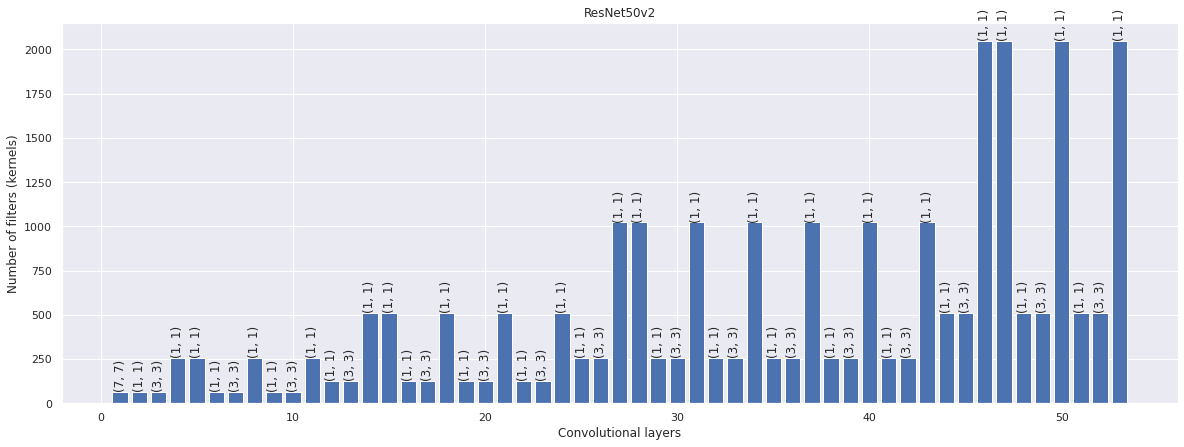

In [24]:
_=shapeNposition_w(model, see=False, plot=True)
#layer_names=positionNnameLayers(modelx, False)

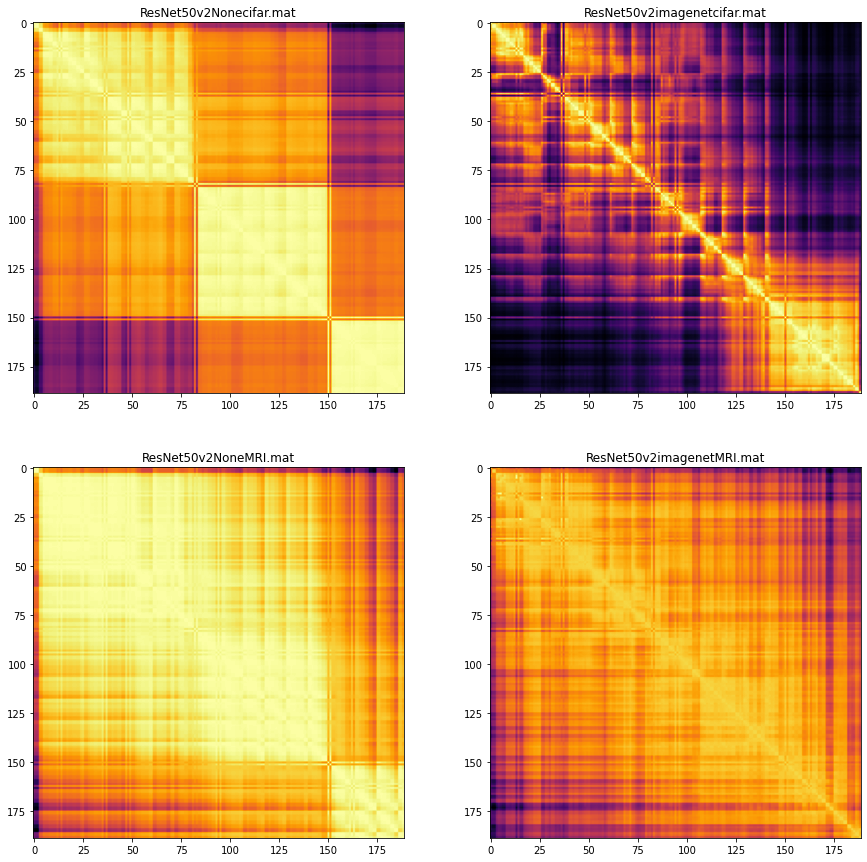

In [18]:
results=glob.glob(path+'*.mat')

plt.figure(figsize=(15,15))
for i in range(4):
  mat=sio.loadmat(results[i])  
  plt.subplot(2,2,i+1)
  plt.imshow(mat['matrix'], cmap='inferno')
  plt.title(results[i][44:])